## Init

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from copy import deepcopy
from transformers import (AutoModelForMaskedLM, AutoModelForCausalLM, AutoTokenizer, AutoModelForTokenClassification,
                          AutoModelForSequenceClassification, TrainingArguments, Trainer)
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tensorflow.keras.models import load_model
from datasets import load_dataset, load_metric
import os
from utils import top_tokens
from tabulate import tabulate

In [2]:
# def get_output_emb(model):
#     transform = model.cls.predictions.transform.dense.weight.T
#     orig_emb = model.get_output_embeddings().weight.T
#     return (transform @ orig_emb).detach().cpu()

In [3]:
tokenizer = AutoTokenizer.from_pretrained('gpt2') # ('bert-base-uncased') # get_multiberts_tokenizer()

In [4]:
class Gpt2AvgClassifier(nn.Module):
    def __init__(self, name, freeze=None, num_labels=2):
        super().__init__()
        self.model = AutoModelForTokenClassification.from_pretrained(name, num_labels=num_labels)
        self.model.transformer.ln_f = nn.Identity(self.model.config.n_ctx)
        if freeze is not None:
            for n, p in self.named_parameters():
                p.requires_grad = False
                if len(n.split('.transformer.h.')) == 2 and n.endswith('.weight'):
                    if int(n.split('.transformer.h.')[1].split('.')[0]) >= freeze:
                        p.requires_grad = True
                        print(n)
                if n.endswith('.classifier.weight'):
                    p.requires_grad = True
                    print(n)
                    
    def forward(self, input_ids, labels, inputs_embeds=None):
        res = self.model(input_ids=input_ids, inputs_embeds=inputs_embeds)
        res.logits = res.logits.mean(dim=-2)
        res['loss'] = F.cross_entropy(res.logits.view(-1, res.logits.shape[-1]), labels.view(-1))
        return res

### Initialize Models

In [5]:
freeze = 9 # number of layers to freeze

In [6]:
model_paths = ['gpt2', 'gpt2-medium'] 

print(model_paths)

model1 = Gpt2AvgClassifier(model_paths[0], freeze=freeze) # AutoModelForSequenceClassification.from_pretrained(model_paths[0])
model2 = AutoModelForSequenceClassification.from_pretrained(model_paths[1])
# we can use input embedding as the embedding matrices are tied
emb1 = model1.model.get_input_embeddings().weight.T.cpu().detach() 
emb2 = model2.get_input_embeddings().weight.T.cpu().detach() 
num_layers1, hidden_dim1 = (model1.model.config.n_layer, model1.model.config.n_embd)
num_layers2, hidden_dim2 = (model2.config.n_layer, model2.config.n_embd)

['gpt2', 'gpt2-medium']


Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.11.attn.masked_bias', 'h.9.attn.masked_bias', 'h.3.attn.masked_bias', 'h.2.attn.masked_bias', 'h.0.attn.masked_bias', 'h.10.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.8.attn.masked_bias', 'classifier.bias', 'h.7.attn.masked_bias', 'h.1.attn.masked_bias', 'classifier.weight', 'h.6.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.transformer.h.9.ln_1.weight
model.transformer.h.9.attn.c_attn.weight
model.transformer.h.9.attn.c_proj.weight
model.transformer.h.9.ln_2.weight
model.transformer.h.9.mlp.c_fc.weight
model.transformer.h.9.mlp.c_proj.weight
model.transformer.h.10.ln_1.weight
model.transformer.h.10.attn.c_attn.weight
model.transformer.h.10.attn.c_proj.weight
model.transformer.h.10.ln_2.weight
model.transformer.h.10.mlp.c_fc.weight
model.transformer.h.10.mlp.c_proj.weight
model.transformer.h.11.ln_1.weight
model.transformer.h.11.attn.c_attn.weight
model.transformer.h.11.attn.c_proj.weight
model.transformer.h.11.ln_2.weight
model.transformer.h.11.mlp.c_fc.weight
model.transformer.h.11.mlp.c_proj.weight
model.classifier.weight


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
pos_emb1 = model1.model.transformer.wpe.weight.data.detach().T.cpu() # (d, pos)
emb_extended1 = torch.cat([emb1, pos_emb1], dim=1)

In [8]:
pos_emb2 = model2.transformer.wpe.weight.data.detach().T.cpu() # (d, pos)
emb_extended2 = torch.cat([emb2, pos_emb2], dim=1)

In [9]:
# model_paths = ['gpt2', 'gpt2-medium'] # ["bert-base-uncased", f"multiberts/models/seed_0"] # [f"multiberts/models/seed_{i}" for i in range(2)]
# print(model_paths)

# model1_tmp = AutoModelForCausalLM.from_pretrained(model_paths[0]) # need to get the output emb matrix from model1
# model2 = AutoModelForCausalLM.from_pretrained(model_paths[1])
# emb1, emb2 = map(lambda model: model.get_output_embeddings().weight.T.cpu().detach(), [model1_tmp, model2])
# del model1_tmp # now we no longer need model1_tmp
# model1 = AutoModelForSequenceClassification.from_pretrained(model_paths[0])

In [10]:
## remove pooler for simplicity - leave only classifier 
# model1.bert.pooler.dense = nn.Identity()
# model1.bert.pooler.activation = nn.Identity()

## Sentiment Analysis Finetuning

In [11]:
model = model1

### Preparing Data

In [12]:
def tokenize_imdb(examples):
    return tokenizer(examples["text"], truncation=True)

In [13]:
imdb = load_dataset('imdb')
imdb = imdb.map(tokenize_imdb, batched=False)
imdb_train, imdb_val = imdb['train'].shuffle().select(range(3000)), imdb['test'].shuffle().select(range(500))
# ..shuffle(seed=42).select(range(1000))

Reusing dataset imdb (/home/guydar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/guydar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-3524c89eaed1ab3e.arrow
Loading cached processed dataset at /home/guydar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-bd746f6e0438ac54.arrow
Loading cached processed dataset at /home/guydar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-fcdd099119f0e220.arrow
Loading cached shuffled indices for dataset at /home/guydar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-0f38f07d8eec9b87.arrow


### Training

In [14]:
metric = load_metric('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
os.environ["WANDB_DISABLED"] = "true"

In [16]:
train_args = TrainingArguments(learning_rate=1e-5, report_to=None, output_dir='trainer_output', 
                               per_device_eval_batch_size=1, per_device_train_batch_size=1, 
                               save_steps=False, evaluation_strategy='epoch', num_train_epochs=1)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [17]:
train_args._n_gpu = 1

In [18]:
old_model = deepcopy(model)

In [19]:
trainer = Trainer(model1, args=train_args, train_dataset=imdb_train, eval_dataset=imdb_val, 
                  compute_metrics=compute_metrics)
trainer.train()

The following columns in the training set don't have a corresponding argument in `Gpt2AvgClassifier.forward` and have been ignored: text, attention_mask. If text, attention_mask are not expected by `Gpt2AvgClassifier.forward`,  you can safely ignore this message.
/mnt/netapp7/dar/miniconda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3000
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 3000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.608900,0.739122,0.860000


The following columns in the evaluation set don't have a corresponding argument in `Gpt2AvgClassifier.forward` and have been ignored: text, attention_mask. If text, attention_mask are not expected by `Gpt2AvgClassifier.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=3000, training_loss=0.8060599873860677, metrics={'train_runtime': 180.0064, 'train_samples_per_second': 16.666, 'train_steps_per_second': 16.666, 'total_flos': 0.0, 'train_loss': 0.8060599873860677, 'epoch': 1.0})

### Visualize Finetuning Vectors

In [20]:
diff_classifier = (model.model.classifier.weight.cpu() - old_model.model.classifier.weight.cpu()).detach()
# diff_classifier = model.score.weight.detach().cpu() - old_model.score.weight.detach()
# diff_classifier = model.classifier.weight.detach().cpu() - old_model.classifier.weight.detach()

In [21]:
neg_vector = diff_classifier[0, :]
pos_vector = diff_classifier[1, :]

In [38]:
print(tabulate(
    [*zip(*[top_tokens(pos_vector @ emb1, k=30, only_ascii=True, tokenizer=tokenizer),
            top_tokens(neg_vector @ emb1, k=30, only_ascii=True, tokenizer=tokenizer)])],
     headers=['POSITIVE', 'NEGATIVE']))

POSITIVE     NEGATIVE
-----------  ------------
#}}}         #failed
GOODMAN      failed
JUSTICE      barren
#psons       wasted
#ochet       inco
#raq         lacked
#eous        Waste
superheroes  wast
#@#&         lifeless
#yip         Poor
#},{"        sparse
bets         Lack
Hebdo        muff
appreciate   #interrupted
#rals        bland
#ulz         stalled
#etheless    Failed
prevail      deteriorated
upholding    inadequate
extrad       omission
extradition  unprepared
LEVEL        unused
ILCS         disappoint
#Jews        degraded
uncond       omitted
defiant      empty
rul          poor
#atz         depleted
#joice       prematurely
nerds        unfinished


In [39]:
i1 = 11 # this is the layer we visualize

In [40]:
diff_K = (model.model.transformer.h[i1].mlp.c_fc.weight.cpu() - old_model.model.transformer.h[i1].mlp.c_fc.weight.cpu()).T
diff_V = (model.model.transformer.h[i1].mlp.c_proj.weight.cpu() - old_model.model.transformer.h[i1].mlp.c_proj.weight.cpu())
diff_WQ, diff_WK, diff_WV = ((model.model.transformer.h[i1].attn.c_attn.weight.cpu() - 
                              old_model.model.transformer.h[i1].attn.c_attn.weight.cpu()).T.chunk(3))
diff_WO = (model.model.transformer.h[i1].attn.c_proj.weight.cpu() - old_model.model.transformer.h[i1].attn.c_proj.weight.cpu())

In [41]:
diff_param = diff_WV

In [42]:
i2 = np.random.randint(diff_param.shape[0]) # index of vector in the parameter

In [43]:
print(tabulate(zip(*[top_tokens(diff_param[i2].detach() @ emb1, k=20, only_ascii=True, tokenizer=tokenizer),
                top_tokens(-diff_param[i2].detach() @ emb1, k=20, only_ascii=True, tokenizer=tokenizer)]), 
               headers=["diff", "-diff"]))

diff         -diff
-----------  ------------
respects     #failed
thrive       stalled
appreciate   failed
#smart       inco
safer        derailed
#worthiness  aborted
smarter      lifeless
deserve      unprepared
deserves     wasted
respect      dissatisf
VERS         ineffective
bravery      #interrupted
#NOW         unfinished
smartest     Unable
#udos        inadequate
enjoys       #empty
JUSTICE      vacant
GOODMAN      inexper
#afe         omitted
#erning      commenced


## Model Stitching

In [20]:
def subtract_modules(mod1, mod2, subtract_ln=False, only_weight=False):
    mod_new = deepcopy(mod1)
    with torch.no_grad():
        for n, p in mod_new.named_parameters():
            if only_weight and not n.endswith('.weight'):
                continue
            submodule_name = n.rsplit('.', 1)[0] if '.' in n else ''
            is_ln = isinstance(mod_new.get_submodule(submodule_name), nn.LayerNorm)
            if (not is_ln) or subtract_ln:
                p.set_(p.data - mod2.get_parameter(n).data)
    return mod_new

In [21]:
class StitchedTransformers(nn.Module):
    def __init__(self, old_model, model1, model2, kernel, num_keep_layers, num_transplanted_layers,
                subtract=True, **subtract_args):
        super().__init__()
        self.model2 = deepcopy(model2) 
        self.model2.transformer.h = nn.ModuleList(self.model2.transformer.h[:num_keep_layers])
        self.register_buffer("stitching_kernel", kernel)     
        self.model1 = deepcopy(model1)
        offset = len(model1.model.transformer.h) - num_transplanted_layers
        self.model1.model.transformer.h = nn.ModuleList([
        subtract_modules(model1.model.transformer.h[offset + i], 
                         old_model.model.transformer.h[offset + i], 
                         **subtract_args) if subtract else model1.model.transformer.h[offset + i]
                                                  for i in range(num_transplanted_layers)])
        self.model1.model.classifier = (
            subtract_modules(model1.model.classifier, old_model.model.classifier, **subtract_args) 
            if subtract else model1.model.classifier
        )
        
    def forward(self, input_ids, labels):
        x = self.model2(input_ids, output_hidden_states=True).hidden_states[-1]
        x = x @ self.stitching_kernel
        res = self.model1(input_ids=None, inputs_embeds=x, labels=labels)
        res = {'loss': res['loss'], 'logits': res['logits']}
        return res

In [22]:
extended = False
kernel = emb_extended2 @ (emb_extended1).pinverse() if extended else emb2 @ (emb1).pinverse()
# + .1 * torch.eye(1024, 768)

In [23]:
subtract = False

In [120]:
num_transplanted_layers = 3
num_keep_layers = 10

### Evaluate

In [121]:
stitched_model = StitchedTransformers(old_model.cuda(), model1, model2, kernel, 
                                      num_keep_layers, num_transplanted_layers, subtract=subtract).cpu()

In [122]:
trainer_stitched = Trainer(stitched_model, args=train_args, train_dataset=imdb_train, eval_dataset=imdb_val, 
                           compute_metrics=compute_metrics)
trainer_stitched.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `StitchedTransformers.forward` and have been ignored: text, attention_mask. If text, attention_mask are not expected by `StitchedTransformers.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1


{'eval_loss': 7.887665271759033,
 'eval_accuracy': 0.522,
 'eval_runtime': 21.7816,
 'eval_samples_per_second': 22.955,
 'eval_steps_per_second': 22.955}

In [123]:
import gc
gc.collect()

3

#### Plot

In [ ]:
accs = []
for num_keep_layers in range(model2.config.n_layer):
    stitched_model = StitchedTransformers(old_model.cuda(), model1, model2, kernel, 
                                          num_keep_layers, num_transplanted_layers, subtract=subtract).cpu()
    trainer_stitched = Trainer(stitched_model, args=train_args, train_dataset=imdb_train, eval_dataset=imdb_val, 
                               compute_metrics=compute_metrics)

    accs.append(trainer_stitched.evaluate()['eval_accuracy'])

The following columns in the evaluation set don't have a corresponding argument in `StitchedTransformers.forward` and have been ignored: text, attention_mask. If text, attention_mask are not expected by `StitchedTransformers.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1


The following columns in the evaluation set don't have a corresponding argument in `StitchedTransformers.forward` and have been ignored: text, attention_mask. If text, attention_mask are not expected by `StitchedTransformers.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1


The following columns in the evaluation set don't have a corresponding argument in `StitchedTransformers.forward` and have been ignored: text, attention_mask. If text, attention_mask are not expected by `StitchedTransformers.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1


The following columns in the evaluation set don't have a corresponding argument in `StitchedTransformers.forward` and have been ignored: text, attention_mask. If text, attention_mask are not expected by `StitchedTransformers.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1


The following columns in the evaluation set don't have a corresponding argument in `StitchedTransformers.forward` and have been ignored: text, attention_mask. If text, attention_mask are not expected by `StitchedTransformers.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1


The following columns in the evaluation set don't have a corresponding argument in `StitchedTransformers.forward` and have been ignored: text, attention_mask. If text, attention_mask are not expected by `StitchedTransformers.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 1


In [539]:
accs

[0.508, 0.512, 0.512, 0.504, 0.516, 0.534, 0.55, 0.568, 0.55, 0.556]

In [44]:
accs

[0.492,
 0.656,
 0.68,
 0.74,
 0.768,
 0.768,
 0.73,
 0.676,
 0.76,
 0.802,
 0.858,
 0.868,
 0.884,
 0.878,
 0.898,
 0.88,
 0.862,
 0.866,
 0.858,
 0.852,
 0.858,
 0.844,
 0.82,
 0.704]

In [43]:
accs

[0.492,
 0.518,
 0.532,
 0.632,
 0.656,
 0.682,
 0.714,
 0.756,
 0.78,
 0.786,
 0.786,
 0.8,
 0.834,
 0.846,
 0.846,
 0.838,
 0.808,
 0.824,
 0.824,
 0.802,
 0.788,
 0.734,
 0.612,
 0.496]

In [38]:
accs

[0.492,
 0.586,
 0.66,
 0.69,
 0.72,
 0.69,
 0.632,
 0.552,
 0.596,
 0.592,
 0.66,
 0.648,
 0.648,
 0.62,
 0.678,
 0.756,
 0.83,
 0.816,
 0.79,
 0.796,
 0.77,
 0.72,
 0.622,
 0.524]

## Experiments

In [53]:
import pandas as pd

In [54]:
def save_model_hist(model,path):
    torch.save(model, f"artifacts/{path}.bin")
    x = [list(p.data.cpu().numpy().reshape(-1)) for n, p in model.named_parameters() if p.requires_grad]
    z = []
    for y in x:
        z.extend(y)
    z = pd.Series(z)
    a = np.log(np.abs(z)).hist(bins=100)
    a.figure.savefig(f"artifacts/{path}.pdf")

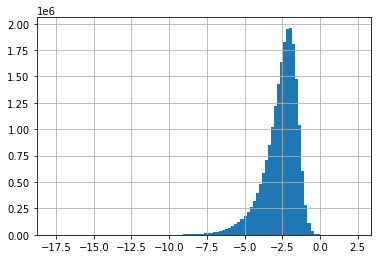

In [56]:
save_model_hist(model1,"tmp")

In [117]:
model_bad = torch.load("artifacts/semigood_result3.bin")

In [118]:
model1 = model_bad

In [116]:
model1 = model_good

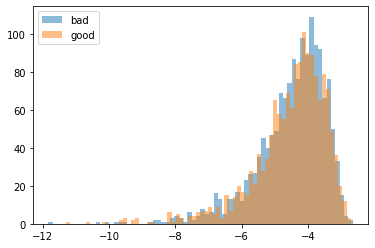

In [82]:
model_good = torch.load("artifacts/good_result1.bin")
plt.hist(model_bad.model.classifier.weight.abs().log().detach().cpu().numpy().flatten(), bins=70, alpha=.5, label='bad');
plt.hist(model_good.model.classifier.weight.abs().log().detach().cpu().numpy().flatten(), bins=70, alpha=.5, label='good');
plt.legend();

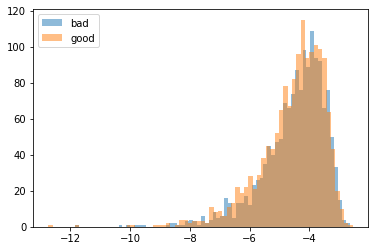

In [59]:
model_good = torch.load("artifacts/good_result2.bin")
plt.hist(model_bad.model.classifier.weight.abs().log().detach().cpu().numpy().flatten(), bins=70, alpha=.5, label='bad');
plt.hist(model_good.model.classifier.weight.abs().log().detach().cpu().numpy().flatten(), bins=70, alpha=.5, label='good');
plt.legend();

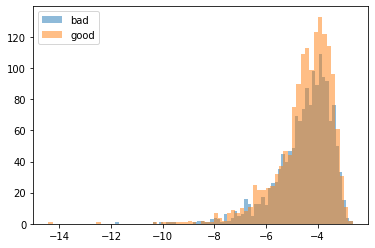

In [60]:
model_good = torch.load("artifacts/good_result3.bin")
plt.hist(model_bad.model.classifier.weight.abs().log().detach().cpu().numpy().flatten(), bins=70, alpha=.5, label='bad');
plt.hist(model_good.model.classifier.weight.abs().log().detach().cpu().numpy().flatten(), bins=70, alpha=.5, label='good');
plt.legend();

In [65]:
model_bad.model.classifier.weight.abs().log().min()

tensor(-11.8291, device='cuda:0', grad_fn=<MinBackward1>)

In [141]:
torch.load("artifacts/bad_result2_very.bin").model.classifier.weight.abs().log().mean()

tensor(-4.5167, device='cuda:0', grad_fn=<MeanBackward0>)

In [143]:
torch.load("artifacts/good_result3.bin").model.classifier.weight.abs().log().mean()

tensor(-4.5099, device='cuda:0', grad_fn=<MeanBackward0>)

In [67]:
torch.load("artifacts/good_result2.bin").model.classifier.weight.abs().log().min()

tensor(-12.7342, device='cuda:0', grad_fn=<MinBackward1>)

In [68]:
torch.load("artifacts/good_result3.bin").model.classifier.weight.abs().log().min()

tensor(-14.4228, device='cuda:0', grad_fn=<MinBackward1>)